In [ ]:
!pip install --upgrade transformers torch transformers[torch] tokenizers huggingface_hub pytorch-crf checklist
!pip install protobuf==3.20.3

In [1]:
import torch
torch.cuda.empty_cache()

assert torch.cuda.is_available()

In [2]:
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: NVIDIA A100-SXM4-80GB MIG 2g.20gb, n_gpu: 1


In [3]:
import random
import numpy as np

# Ensure reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_everything()

### Set the hyperparameters

In [4]:
# Set the hyperparameters according to Table 8
dropout = 0.2
learning_rates = [5e-5, 6e-5, 7e-5]  # Perform hyperparameter search
batch_size = 12
gradient_accumulation_steps = 4
weight_decay = 0
max_epochs = 10
lr_decay = "slanted_triangular"
fraction_of_steps = 0.06
adam_epsilon = 1e-8
adam_beta1 = 0.9
adam_beta2 = 0.999

seed_everything()

## Preprocessing

In [5]:
import pandas as pd

def read_conll(file_path):
    sentences = []
    labels = []
    current_sentence = []
    current_labels = []

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                columns = line.split()
                word, label = columns[0], columns[-1]
                current_sentence.append(word)
                current_labels.append(label)
                
                # Check if the current word is a sentence boundary
                if word == '.' and label == 'O':
                    sentences.append(' '.join(current_sentence))
                    labels.append(current_labels)
                    current_sentence = []
                    current_labels = []

    # Create a DataFrame from the accumulated sentences and labels
    df = pd.DataFrame({
        'sentences': sentences,
        'labels': labels
    })
    return df


In [6]:
import torch
max_length=128

def tokenize_and_format(sentences, tokenizer, max_length=max_length):
    """
    Tokenizes sentences and returns formatted input IDs and attention masks.
    
    Parameters:
    sentences: List of sentence strings to be tokenized.
    tokenizer: Tokenizer instance used for tokenizing the sentences.
    """
    input_ids = []
    attention_masks = []

    # Encode each sentence
    for sentence in sentences:
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=max_length,  # Adjust based on your model's maximum input length
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Store the input ID and the attention mask of this sentence
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert lists of tensors to single tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

In [7]:
from enum import Enum

# Define an enum for model names
class ModelName(Enum):
    BERT = 'google-bert/bert-base-uncased'
    BERT_multilingual = 'google-bert/bert-base-multilingual-uncased'
    ROBERTA = 'FacebookAI/roberta-base'
    XLM_ROBERTA = 'FacebookAI/xlm-roberta-base'
    MDEBERTA = 'microsoft/mdeberta-v3-base'
    ECONBERTA_FC = 'worldbank/econberta'
    ECONBERTA_FS = 'worldbank/econberta-fs'
    

### Select model and tokenizer

In [8]:
from transformers import AutoTokenizer

model_name = ModelName.ECONBERTA_FC.value
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

/home/apathak2/.local/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [9]:
label_dict = {
    'O': 0,
    'B-intervention': 1,
    'I-intervention': 2,
    'B-outcome': 3,
    'I-outcome': 4,
    'B-population': 5,
    'I-population': 6,
    'B-effect_size': 7,
    'I-effect_size': 8,
    'B-coreference': 9,
    'I-coreference': 10
}

In [10]:
reverse_label_dict = {v: k for k, v in label_dict.items()}

In [11]:
import numpy as np
import torch

def get_dataset(df, tokenizer, label_dict, max_length=max_length):
    """
    Processes a DataFrame to return a dataset suitable for training/testing an NER model.
    
    Parameters:
    df: DataFrame containing 'Tokens' and 'Labels' columns.
    tokenizer: Tokenizer to use for encoding the sentences.
    label_dict: Dictionary mapping label names to indices.
    max_length: Maximum length of the tokenized input.
    """
    sentences = df.sentences.values
    
    # Tokenize sentences
    input_ids, attention_masks = tokenize_and_format(sentences, tokenizer, max_length)

    # Prepare labels
    label_list = []
    for labels in df.labels.values:
        # Initialize a list to hold the encoded labels for each sentence
        encoded_labels = [label_dict[label] for label in labels]
        
        # Truncate or pad the labels to match the max_length
        encoded_labels = encoded_labels[:max_length]  # Truncate if needed
        encoded_labels += [label_dict['O']] * (max_length - len(encoded_labels))  # Pad with 'O' if needed
        
        label_list.append(encoded_labels)

    # Convert label_list to a tensor
    labels = torch.tensor(label_list, dtype=torch.long)

    # Create the dataset
    dataset = [(input_ids[i], attention_masks[i], labels[i]) for i in range(len(df))]

    return dataset, sentences

In [12]:
seed_everything()

train_df = read_conll('../data/econ_ie/train.conll')
val_df = read_conll('../data/econ_ie/dev.conll')
test_df = read_conll('../data/econ_ie/test.conll')

train_set, train_sentences = get_dataset(train_df, tokenizer, label_dict)
val_set, val_sentences = get_dataset(val_df, tokenizer, label_dict)
test_set, test_sentences = get_dataset(test_df, tokenizer, label_dict)

In [13]:
train_set[0]

(tensor([    1,   287,   376,  1263,  1770,   268, 11254,   264,  5685, 17736,
           267,  4770,  3791,   263,  3922,   323,     2,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [14]:
def preprocess_entities(labels, tokens):
    """
    Extract entities from token-label pairs.
    
    Args:
    labels (list of int): List of label indices corresponding to each token.
    tokens (list of str): List of tokens corresponding to each label index.
    
    Returns:
    list of tuples: Each tuple represents an entity with (entity_type, start_index, end_index, entity_text).
    """
    entities = []
    current_entity = None

    for i, (token, label) in enumerate(zip(tokens, labels)):
        if label.startswith("B-"):
            if current_entity:
                entities.append(current_entity)
            entity_type = label.split("-")[1]
            current_entity = (entity_type, i, i, token)
        elif label.startswith("I-") and current_entity and label.split("-")[1] == current_entity[0]:
            current_entity = (current_entity[0], current_entity[1], i, current_entity[3] + " " + token)
        else:
            if current_entity:
                entities.append(current_entity)
                current_entity = None

    if current_entity:
        entities.append(current_entity)

    return entities

In [15]:
def compute_entity_level_metrics(true_entities, pred_entities):
    metrics = {"EM": 0, "EB": 0, "PM": 0, "PB": 0, "ML": 0, "FA": 0}
    true_matched = set()
    pred_matched = set()

    # Check for exact and partial matches
    for i, true_entity in enumerate(true_entities):
        for j, pred_entity in enumerate(pred_entities):
            if j in pred_matched:
                continue
            if true_entity == pred_entity:
                metrics["EM"] += 1
                true_matched.add(i)
                pred_matched.add(j)
                break
            elif true_entity[0] == pred_entity[0] and is_overlapping((true_entity[1], true_entity[2]), (pred_entity[1], pred_entity[2])):
                if true_entity[1] == pred_entity[1] and true_entity[2] == pred_entity[2]:
                    metrics["EB"] += 1
                else:
                    metrics["PM"] += 1
                true_matched.add(i)
                pred_matched.add(j)
                break
            elif is_overlapping((true_entity[1], true_entity[2]), (pred_entity[1], pred_entity[2])):
                metrics["PB"] += 1
                true_matched.add(i)
                pred_matched.add(j)
                break

    # Check for missed labels (entities in true but not in pred)
    for i, true_entity in enumerate(true_entities):
        if i not in true_matched:
            metrics["ML"] += 1

    # Check for false alarms (entities in pred but not in true)
    for j, pred_entity in enumerate(pred_entities):
        if j not in pred_matched:
            metrics["FA"] += 1

    return metrics

In [16]:
def is_overlapping(span1, span2):
    """
    Check if two spans overlap.
    Args:
    span1, span2 (tuple): (start_index, end_index) of the span.

    Returns:
    bool: True if spans overlap, False otherwise.
    """
    assert len(span1) == 2 and len(span2) == 2, "Each span must be a tuple of two elements (start_index, end_index)"
    start1, end1 = span1
    start2, end2 = span2
    return max(start1, start2) <= min(end1, end2)

In [17]:
print(label_dict)

{'O': 0, 'B-intervention': 1, 'I-intervention': 2, 'B-outcome': 3, 'I-outcome': 4, 'B-population': 5, 'I-population': 6, 'B-effect_size': 7, 'I-effect_size': 8, 'B-coreference': 9, 'I-coreference': 10}


In [18]:
from collections import defaultdict

def analyze_generalization(model, data, tokenizer, train_words):
    grouped_entities = defaultdict(lambda: ([], []))  # {group_name: (true_entities, pred_entities)}        
    groups=[]
    mtrcs=[]

    for i, (input_ids, attention_mask, label_tensor) in enumerate(data):
        input_ids = input_ids.unsqueeze(0).to(device)
        attention_mask = attention_mask.unsqueeze(0).to(device)
        
        # Call model without labels to get the decoded labels
        with torch.no_grad():
            decoded_labels = model(input_ids, attention_mask=attention_mask)["decoded"][0]
            # No need to use argmax since CRF.decode returns the most likely tag sequence
        
        # Convert the decoded labels to label names using label_dict
        pred_labels = [reverse_label_dict.get(label) for label in decoded_labels]

        # Convert input_ids to tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist(), skip_special_tokens=True)

        # Assuming true_labels are provided in a similar structure
        true_labels = [reverse_label_dict.get(l.item()) for l in label_tensor]
        
        # Preprocess entities for true and predicted labels
        true_entities = preprocess_entities(true_labels, tokens)
        pred_entities = preprocess_entities(pred_labels, tokens)
        
        for true_entity, pred_entity in zip(true_entities, pred_entities):
            length = true_entity[2] - true_entity[1]

            seen = any(word in train_words for word in true_entity[3].split())  # Check if any word in entity text was seen in training

            group_name = f"Length {length} - {'Seen' if seen else 'Unseen'}"
            grouped_entities[group_name][0].append(true_entity)
            grouped_entities[group_name][1].append(pred_entity)
    
    for group_name, group_data in grouped_entities.items():
        group_true_entities, group_pred_entities = group_data
        metrics = compute_entity_level_metrics(group_true_entities, group_pred_entities)
        print(f"Group: {group_name}, Metrics: {metrics}")
        groups.append(group_name)
        mtrcs.append(metrics)
        
    return groups, mtrcs

## Eval method

In [19]:
from sklearn.metrics import classification_report
import torch
import numpy as np

def get_validation_performance(val_set, model, device, label_dict, batch_size):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables
    total_eval_loss = 0
    all_pred_labels = []
    all_true_labels = []

    num_batches = int(len(val_set) / batch_size) + (1 if len(val_set) % batch_size != 0 else 0)

    for i in range(num_batches):
        end_index = min(batch_size * (i + 1), len(val_set))
        batch = val_set[i * batch_size:end_index]

        if len(batch) == 0:
            continue

        input_id_tensors = torch.stack([data[0] for data in batch])
        input_mask_tensors = torch.stack([data[1] for data in batch])
        label_tensors = torch.stack([data[2] for data in batch])

        # Move tensors to the GPU
        b_input_ids = input_id_tensors.to(device)
        b_input_mask = input_mask_tensors.to(device)
        b_labels = label_tensors.to(device)
        b_labels = b_labels.long()

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs["loss"]
            logits = outputs["logits"]

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Get the predicted labels
            pred_labels = np.argmax(logits, axis=2).flatten()
            true_labels = label_ids.flatten()

            # Convert labels to their original names
            pred_labels = [reverse_label_dict.get(label) for label in pred_labels]
            true_labels = [reverse_label_dict.get(label) for label in true_labels]

            # Filter out special tokens ('O' label is used for non-entity and special tokens)
            filtered_pred_labels = [pred for pred, true in zip(pred_labels, true_labels) if true != 'O']
            filtered_true_labels = [true for true in true_labels if true != 'O']
            
            # After filtering out special tokens
            if not filtered_pred_labels or not filtered_true_labels:
                print("Warning: No non-'O' labels found in this batch.")
            else:
                all_pred_labels.extend(filtered_pred_labels)
                all_true_labels.extend(filtered_true_labels)
            
    # After processing all batches, check if we have any labels to report on
    if not all_true_labels or not all_pred_labels:
        print("Error: No non-'O' labels found in the entire validation set.")
        default_labels = [list(label_dict.values())[0]]  # Use the first label as a placeholder
        report = classification_report(default_labels, default_labels, digits=4, zero_division=0)
    else:
        # Calculate precision, recall, and F1 score
        report = classification_report(all_true_labels, all_pred_labels, digits=4, zero_division=0)

    return report


## Define Model

In [20]:
from torchcrf import CRF
from transformers import AutoModel

class CRFTagger(torch.nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, num_labels)
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        # Mask should be of type 'bool' in newer PyTorch versions
        mask = attention_mask.type(torch.bool) if hasattr(torch, 'bool') else attention_mask.byte()
        
        if labels is not None:
            loss = -self.crf(logits, labels, mask=mask, reduction='mean')
            return {'loss': loss, 'logits': logits, 'decoded': self.crf.decode(logits, mask=mask)}
        else:
            decoded_labels = self.crf.decode(logits, mask=mask)
            return {'decoded': decoded_labels, 'logits': logits}

In [21]:
seed_everything()

# Load the pre-trained model
model = CRFTagger(model_name, len(label_dict))
model.dropout = torch.nn.Dropout(dropout)
model.to(device)

CRFTagger(
  (bert): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
              (dropou

In [22]:
def extract_model_name(full_string):
    # Split the string by the '/' character
    parts = full_string.split('/')
    if len(parts) == 2:
        return parts[1]  # The second part is the model name
    else:
        raise ValueError(f"Invalid model_name format. Actual: {full_string}, Expected: 'org_name/model_name'.")  # Invalid format

## Train

In [ ]:
from transformers import get_linear_schedule_with_warmup, AdamW
import time

# Calculate the total number of training steps
total_steps = (len(train_set) // (batch_size * gradient_accumulation_steps)) * max_epochs


for lr in learning_rates:
    print(f"Current learning rate: {lr}")

    # Create the optimizer with the specified hyperparameters
    optimizer = AdamW(model.parameters(), lr=lr, eps=adam_epsilon, betas=(adam_beta1, adam_beta2), weight_decay=weight_decay, no_deprecation_warning=True)

    # Create the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(total_steps * fraction_of_steps), num_training_steps=total_steps)

    # Training loop
    for epoch_i in range(max_epochs):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, max_epochs))
        print('Training...')

        total_train_loss = 0
        model.train()

        num_batches = int(len(train_set) / batch_size) + (1 if len(train_set) % batch_size != 0 else 0)

        for i in range(num_batches):
            end_index = min(batch_size * (i + 1), len(train_set))
            batch = train_set[i * batch_size:end_index]

            if len(batch) == 0:
                continue

            input_id_tensors = torch.stack([data[0] for data in batch])
            input_mask_tensors = torch.stack([data[1] for data in batch])
            label_tensors = torch.stack([data[2] for data in batch])

            b_input_ids = input_id_tensors.to(device)
            b_input_mask = input_mask_tensors.to(device)
            b_labels = label_tensors.long().to(device)

            model.zero_grad()
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs["loss"]
            total_train_loss += loss.item()

            # Accumulate gradients
            loss = loss / gradient_accumulation_steps
            loss.backward()

            # Perform optimizer step after accumulating gradients for gradient_accumulation_steps
            if (i + 1) % gradient_accumulation_steps == 0 or i == num_batches - 1:  # Ensure step is taken on the last batch
                optimizer.step()
                scheduler.step()
                model.zero_grad()

        print(f"Total loss: {total_train_loss}")
        report = get_validation_performance(val_set, model, device, label_dict, batch_size)
        print(report)
        analyze_generalization(model, val_set, tokenizer, train_sentences)

    print("")
    print(f"Training complete at learning rate: {lr}!")

    timestamp = time.strftime("%Y%m%d-%H%M%S")
    model_name = extract_model_name(model_name)
    print(f"{model_name} model with lr {lr} saved at: {timestamp}")
    torch.save(model.state_dict(), f'../models/{model_name}_{lr}_{timestamp}.pth')

print("")
print(f"Training complete!")

## Test

In [23]:
# Load variables for evaluation
model_name = extract_model_name(model_name)
print(model_name)
lr = learning_rates[2]  # [5e-5, 6e-5, 7e-5]
print(lr)

econberta
7e-05


In [24]:
# Load state_dict of the model
model.load_state_dict(torch.load(f'../models/{model_name}_{lr}_best.pth'))

<All keys matched successfully>

In [25]:
print(get_validation_performance(test_set, model, device, label_dict, batch_size))

                precision    recall  f1-score   support

 B-coreference     0.8875    0.5018    0.6411       550
 B-effect_size     0.6686    0.3594    0.4675       320
B-intervention     0.7324    0.5805    0.6477      1330
     B-outcome     0.6894    0.5774    0.6284      1718
  B-population     0.7564    0.6130    0.6772      1018
 I-coreference     0.0000    0.0000    0.0000        22
 I-effect_size     0.8259    0.4232    0.5597       482
I-intervention     0.8688    0.6241    0.7264      2663
     I-outcome     0.8853    0.5966    0.7128      3235
  I-population     0.8762    0.5998    0.7121      1227
             O     0.0000    0.0000    0.0000         0

      accuracy                         0.5819     12565
     macro avg     0.6537    0.4433    0.5248     12565
  weighted avg     0.8182    0.5819    0.6778     12565



In [26]:
lengths, metrics = analyze_generalization(model, test_set, tokenizer, train_sentences)

Group: Length 3 - Unseen, Metrics: {'EM': 8, 'EB': 6, 'PM': 100, 'PB': 175, 'ML': 13, 'FA': 13}
Group: Length 4 - Unseen, Metrics: {'EM': 13, 'EB': 2, 'PM': 57, 'PB': 103, 'ML': 8, 'FA': 8}
Group: Length 0 - Unseen, Metrics: {'EM': 128, 'EB': 266, 'PM': 107, 'PB': 1076, 'ML': 80, 'FA': 80}
Group: Length 2 - Unseen, Metrics: {'EM': 41, 'EB': 20, 'PM': 148, 'PB': 286, 'ML': 22, 'FA': 22}
Group: Length 1 - Unseen, Metrics: {'EM': 89, 'EB': 53, 'PM': 288, 'PB': 638, 'ML': 41, 'FA': 41}
Group: Length 5 - Unseen, Metrics: {'EM': 10, 'EB': 1, 'PM': 44, 'PB': 73, 'ML': 10, 'FA': 10}
Group: Length 7 - Unseen, Metrics: {'EM': 0, 'EB': 0, 'PM': 20, 'PB': 27, 'ML': 3, 'FA': 3}
Group: Length 10 - Unseen, Metrics: {'EM': 0, 'EB': 0, 'PM': 4, 'PB': 9, 'ML': 2, 'FA': 2}
Group: Length 11 - Unseen, Metrics: {'EM': 0, 'EB': 0, 'PM': 3, 'PB': 3, 'ML': 2, 'FA': 2}
Group: Length 6 - Unseen, Metrics: {'EM': 0, 'EB': 0, 'PM': 32, 'PB': 62, 'ML': 6, 'FA': 6}
Group: Length 8 - Unseen, Metrics: {'EM': 3, 'EB': 0

## Plot

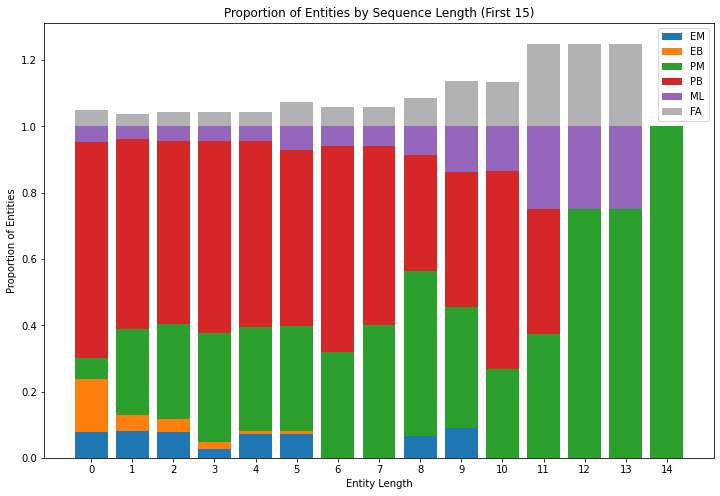

In [27]:
import matplotlib.pyplot as plt

# Extract sequence lengths and sort data by sequence length
sequence_lengths = [int(s.split()[1]) for s in lengths]
sorted_indices = sorted(range(len(sequence_lengths)), key=lambda x: sequence_lengths[x])
sequence_lengths = [sequence_lengths[i] for i in sorted_indices]

# Calculate proportions for each metric, excluding 'False Alarm'
metrics_keys = ['EM', 'EB', 'PM', 'PB', 'ML']  # Exclude 'FA' from this list
proportions = {key: [] for key in metrics_keys}
false_alarms = []

# Calculate the total counts for each sequence length, excluding 'False Alarm'
totals_per_length = [sum(metrics[i][key] for key in metrics_keys) for i in sorted_indices]

# Calculate the proportions for each metric relative to the total counts per sequence length
for i, total in enumerate(totals_per_length):
    for key in metrics_keys:
        proportions[key].append(metrics[sorted_indices[i]][key] / total if total > 0 else 0)
    # Calculate the 'False Alarm' proportion relative to the total counts per sequence length
    false_alarms.append(metrics[sorted_indices[i]]['FA'] / total if total > 0 else 0)

# Plot each metric using stacked bar graphs for the first 15 sequence lengths
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figure size as needed

# Positions of the bars on the x-axis
indices = range(len(sequence_lengths[:15]))

# Initialize the bottom for the stack
bottom = [0] * 15

# Plot the metrics, excluding 'False Alarm'
for key in metrics_keys:
    ax.bar(indices, proportions[key][:15], bottom=bottom, label=key)
    # Update the bottom position for the next metric
    bottom = [bottom[i] + proportions[key][i] for i in range(15)]

# Now plot 'False Alarm' above the stacked bars
ax.bar(indices, false_alarms[:15], bottom=bottom, label='FA', color='k', alpha=0.3)  # 'k' is for black

# Labeling
ax.set_xlabel('Entity Length')
ax.set_ylabel('Proportion of Entities')
ax.set_title('Proportion of Entities by Sequence Length (First 15)')
ax.set_xticks(indices)
ax.set_xticklabels(sequence_lengths[:15])
ax.legend()

plt.show()


## Robustness Tests

In [28]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/apathak2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [29]:
import checklist
from checklist.editor import Editor
from checklist.perturb import Perturb
from checklist.test_types import MFT, INV, DIR
from checklist.expect import Expect
editor = Editor()

2024-05-03 23:35:32.254731: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/sw/other/apps/cudnn/cudnn-linux-x86_64-8.9.7.29_cuda12-archive/lib:/opt/sw/other/apps/cuda/12.3.1/lib64:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/openmpi-4.1.2-4a/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/tcl-8.6.11-d4/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/sqlite-3.37.1-6s/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/zlib-1.2.11-2y/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-9.3.0/gcc-10.3.0-ya/lib64:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-9.3.0/gcc-10.3.0-ya/lib
2024-05-03 23:35:32.254772: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on 

In [30]:
def extract_entities(df):
    # Assuming df has columns 'sentences' and 'labels'
    entities = []
    current_entity = None

    for index, row in df.iterrows():
        sentence = row['sentences']
        labels = row['labels']
        words = sentence.split()

        for i, (word, label) in enumerate(zip(words, labels)):
            if label.startswith('B-'):
                if current_entity:
                    entities.append(current_entity)
                current_entity = {'type': label[2:], 'start_idx': i, 'end_idx': i, 'text': word}
            elif label.startswith('I-') and current_entity and label[2:] == current_entity['type']:
                current_entity['end_idx'] = i
                current_entity['text'] += ' ' + word
            else:
                if current_entity:
                    entities.append(current_entity)
                    current_entity = None

        if current_entity:
            entities.append(current_entity)
            current_entity = None

    return entities

In [31]:
entities = extract_entities(train_df)
print(len(entities))

15872


In [32]:
entities = entities[:1000]

### MFTs

In [33]:
# Define templates with placeholders for entities
population_templates_mft = (
    'The study focused on {population}.',
    'Results were most significant among {population}.',
    'The impact on {population} was noteworthy.',
    'Interventions were targeted towards {population}.',
    'Data was collected from various {population}.',
    'The {population} showed a remarkable response.',
    'Surveys were conducted across different {population}.',
    'The {population} was observed for changes.',
    'A significant change was recorded in the {population}.',
    'The research aimed to benefit the {population}.'
)

intervention_templates_mft = (
    "The {intervention} was implemented to address the issue.",
    "Researchers studied the effects of the {intervention}.",
    "The {intervention} had a significant impact on the community.",
    "Funding was provided for the {intervention}.",
    "The success of the {intervention} was evident in the results.",
    "Participants were selected for the {intervention} group.",
    "The {intervention} was a key part of the strategy.",
    "The {intervention} targeted specific outcomes.",
    "Outcomes were measured after the {intervention} took place.",
    "The {intervention} was designed to improve overall outcomes."
)

outcome_templates_mft = (
    "The outcome of the study was {outcome}.",
    "It was observed that the primary outcome was {outcome}.",
    "The expected outcome was {outcome}, which was surprising.",
    "As a result, the outcome was {outcome}.",
    "The final outcome, {outcome}, was recorded after the experiment.",
    "The result of the intervention was {outcome}.",
    "The project led to {outcome}.",
    "The consequences were observed as {outcome}.",
    "The end effect was {outcome}.",
    "The study concluded with {outcome}."
)

effect_size_templates_mft = (
    "The observed change was {effect_size}.",
    "A {effect_size} increase was noted in the study.",
    "The results showed a {effect_size} decrease.",
    "There was a {effect_size} improvement over the baseline.",
    "The effect was quantified as {effect_size}.",
    "The magnitude of impact measured {effect_size}.",
    "The statistical significance reached {effect_size}.",
    "A {effect_size} reduction in errors was achieved.",
    "The intervention led to a {effect_size} enhancement.",
    "The data indicated a {effect_size} growth rate."
)

coreference_templates_mft = (
    "This refers to the {coreference}.",
    "Such instances of {coreference} were noted.",
    "As mentioned earlier, the {coreference} plays a crucial role.",
    "This is similar to the {coreference} discussed before.",
    "The case of {coreference} is particularly interesting.",
    "In light of the {coreference}, further analysis is required.",
    "This aligns with the {coreference} we observed.",
    "The {coreference} under discussion was pivotal.",
    "Reflecting on the {coreference}, it becomes clear.",
    "Given the {coreference}, the results are unsurprising."
)

In [34]:
# Define custom entities
populations = [entity['text'] for entity in entities if entity['type']=='population']
interventions = [entity['text'] for entity in entities if entity['type']=='intervention']
outcomes = [entity['text'] for entity in entities if entity['type']=='outcome']
effect_sizes = [entity['text'] for entity in entities if entity['type']=='effect_size']
coreferences = [entity['text'] for entity in entities if entity['type']=='coreference']

In [35]:
# Use the editor to create examples
population_test_cases = editor.template(
    population_templates_mft, 
    meta=True,
    remove_duplicates=True,
    population=populations
)

intervention_test_cases = editor.template(
    intervention_templates_mft, 
    meta=True,
    remove_duplicates=True,
    intervention=interventions
)

outcome_test_cases = editor.template(
    outcome_templates_mft, 
    meta=True,
    remove_duplicates=True,
    outcome=outcomes
)

effect_size_test_cases = editor.template(
    effect_size_templates_mft, 
    meta=True,
    remove_duplicates=True,
    effect_size=effect_sizes
)

coreference_test_cases = editor.template(
    coreference_templates_mft, 
    meta=True,
    remove_duplicates=True,
    coreference=coreferences
)

In [36]:
def found_population(x, pred, conf, label=None, meta=None):
    # Check if 'population' is the only entity type present in the prediction
    return all(label == 'O' or label.endswith('population') for label in pred)

def found_intervention(x, pred, conf, label=None, meta=None):
    # Check if 'intervention' is the only entity type present in the prediction
    return all(label == 'O' or label.endswith('intervention') for label in pred)

def found_outcome(x, pred, conf, label=None, meta=None):
    # Check if 'outcome' is the only entity type present in the prediction
    return all(label == 'O' or label.endswith('outcome') for label in pred)

def found_effect_size(x, pred, conf, label=None, meta=None):
    # Check if 'effect_size' is the only entity type present in the prediction
    return all(label == 'O' or label.endswith('effect_size') for label in pred)

def found_coreference(x, pred, conf, label=None, meta=None):
    # Check if 'coreference' is the only entity type present in the prediction
    return all(label == 'O' or label.endswith('coreference') for label in pred)

In [37]:
found_population_expect_fn = Expect.single(found_population)
found_intervention_expect_fn = Expect.single(found_intervention)
found_outcome_expect_fn = Expect.single(found_outcome)
found_effect_size_expect_fn = Expect.single(found_effect_size)  
found_coreference_expect_fn = Expect.single(found_coreference)

In [119]:
# Some simple MFT tests
found_population_test = MFT(
    **population_test_cases,
    name='Test for correct population recognition',
    capability='NER',
    description='The model should correctly identify and label populations.',
    expect=found_population_expect_fn
)

found_intervention_test = MFT(
    **intervention_test_cases,
    name='Test for correct intervention recognition',
    capability='NER',
    description='The model should correctly identify and label interventions.',
    expect=found_intervention_expect_fn
)

found_outcome_test = MFT(
    **outcome_test_cases,
    name='Test for correct outcome recognition',
    capability='NER',
    description='The model should correctly identify and label outcomes.',
    expect=found_outcome_expect_fn
)

found_effect_size_test = MFT(
    **effect_size_test_cases,
    name='Test for correct effect-size recognition',
    capability='NER',
    description='The model should correctly identify and label effect-size.',
    expect=found_effect_size_expect_fn
)

found_coreference_test = MFT(
    **coreference_test_cases,
    name='Test for correct coreference recognition',
    capability='NER',
    description='The model should correctly identify and label coreference.',
    expect=found_coreference_expect_fn
)

In [120]:
seed_everything()

def predict_mft(texts):
    # Extract just the sentences from the input tuples
    sentences = [text for text in texts]
    
    # Convert texts to input IDs and attention masks using the tokenizer
    input_ids, attention_mask = tokenize_and_format(sentences, tokenizer, max_length)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    
    # Use the model to get the logits
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    # Decode the outputs using the CRF layer
    decoded_labels = outputs['decoded']
    
    # Convert label indices to label names
    pred_labels = [[reverse_label_dict[label] for label in sentence_labels] for sentence_labels in decoded_labels]
    return pred_labels

In [121]:
from checklist.pred_wrapper import PredictorWrapper
predict_and_conf_mft = PredictorWrapper.wrap_predict(predict_mft)

In [122]:
from checklist.test_suite import TestSuite

seed_everything()

mft_suite = TestSuite()
mft_suite.add(found_population_test)
mft_suite.add(found_intervention_test)
mft_suite.add(found_outcome_test)
mft_suite.add(found_effect_size_test)
mft_suite.add(found_coreference_test)

### DIR Tests

In [123]:
def compare_predictions(orig_pred, pred, orig_conf, conf, label=None, meta=None):
    # Check if the predicted labels remain consistent despite changes in the entity
    return orig_pred==pred

compare_expect_fn = Expect.pairwise(compare_predictions)

In [124]:
all_templates = [
    '{intervention} was shown to lead to {outcome}.',
    'In a study with {population}, the {effect_size} of {intervention} on {outcome} was significant.',
    'The effect of {intervention} on {outcome} was mediated by {coreference}.',
    '{population} benefited from {intervention}, which resulted in {outcome}.',
    'Despite {coreference}, {intervention} had no significant {effect_size} on {outcome} among {population}.'
]

# Define templates with placeholders for numeric entities
numeric_templates = [
    "The company reported a revenue of ${revenue} million last quarter.",
    "A total of {employees} employees work at the company.",
    "The company's stock rose by {percentage}% after the announcement."
]

# Define templates with placeholders for named entities
punctuation_templates = [
    "The company {company} announced a new product.",
    "The company {company} announced a new product; it expects high sales.",
    "Did the company {company} announce a new product today?",
    "The company {company}—known for its innovative solutions—announced a new product."
]

In [125]:
all_test_cases = editor.template(
    all_templates, 
    remove_duplicates=True,
    population=populations,
    intervention=interventions,
    outcome=outcomes,
    effect_size=effect_sizes,
    coreference=coreferences,
    nsamples=500
)

# Use the editor to create examples with original numeric entities
numeric_test_cases = editor.template(
    numeric_templates,
    remove_duplicates=True,
    revenue=["100", "200", "300"],
    employees=["1000", "2000", "3000"],
    percentage=["5", "10", "15"]
)

# Use the editor to create examples with original entities
punctuation_test_cases = editor.template(
    punctuation_templates,
    remove_duplicates=True,
    company=["Apple Inc.", "Google LLC", "Amazon.com Inc."]
)

In [126]:
# Define a function to apply numeric replacements
def apply_numeric_replacement(texts):
    # Initialize a list to store the results
    results = []
    for text in texts:
        # Iterate over each text in the input list
        replacements = [
            text.replace('million', 'billion'),
            text.replace('employees', 'workers'),
            text.replace('%', ' percent')
        ]
        # Append the modified texts to the results list
        results.extend(replacements)
    return results

# Define a function to apply punctuation variations
def apply_punctuation_variation(texts):
    results = []
    for text in texts:
        # Replace commas with semicolons, add question marks, etc.
        variations = [
            text.replace(',', ';'),
            text.replace('.', '?'),
            text.replace('—', '-')
        ]
        # Append the modified texts to the results list
        results.extend(variations)
    return results

In [127]:
# Apply perturbations to the data
perturbed_test_cases = Perturb.perturb(all_test_cases.data, Perturb.add_typos)
# Apply numeric replacements
perturbed_numeric_cases = Perturb.perturb(numeric_test_cases.data, perturb_fn=apply_numeric_replacement, keep_original=True)
# Apply punctuation variations
perturbed_punctuation_cases = Perturb.perturb(punctuation_test_cases.data, apply_punctuation_variation)

In [128]:
# A DIR test to check the robustness of the model against typos
typo_robustness_test = DIR(
    perturbed_test_cases.data,
    name='Test for robustness against typos in data',
    capability='NER',
    description='The model should maintain consistent predictions before and after adding typos.',
    expect=compare_expect_fn
)

# Create the DIR test
numeric_test = DIR(
    **perturbed_numeric_cases,
    name='Numeric Replacement Test',
    capability='NER',
    description='The model should maintain consistent predictions before and after numeric replacements.',
    expect=compare_expect_fn
)

# Create the DIR test
punctuation_test = DIR(
    **perturbed_punctuation_cases,
    name='Punctuation Variation Test',
    capability='NER',
    description='The model should maintain consistent predictions before and after punctuation variations.',
    expect=compare_expect_fn
)

In [129]:
# mft_suite.add(typo_robustness_test)
# mft_suite.add(numeric_test)
# mft_suite.add(punctuation_test)

In [130]:
mft_suite.run(predict_and_conf_mft)
mft_suite.summary()

Running Test for correct population recognition
Predicting 187 examples
Running Test for correct intervention recognition
Predicting 250 examples
Running Test for correct outcome recognition
Predicting 357 examples
Running Test for correct effect-size recognition
Predicting 94 examples
Running Test for correct coreference recognition
Predicting 112 examples
NER

Test for correct population recognition
Test cases:      187
Fails (rate):    187 (100.0%)

Example fails:
['B-coreference', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'] Interventions were targeted towards Veracruz.

----
['B-coreference', 'O', 'O', 'O', 'B-population', 'O', 'O', 'O'] Interventions were targeted towards children.

----
['B-coreference', 'O', 'O', 'O', 'B-population', 'O', 'O', 'O'] Interventions were targeted towards women.

----


Test for correct intervention recognition
Test cases:      250
Fails (rate):    5 (2.0%)

Example fails:
['O', 'O', 'B-intervention', 'O', 'O', 'B-outcome', 'O', 'O', 'O', 'O', 'O', 'O', 

In [131]:
mft_suite.visual_summary_table()

Please wait as we prepare the table data...


SuiteSummarizer(stats={'npassed': 0, 'nfailed': 0, 'nfiltered': 0}, test_infos=[{'name': 'Test for correct pop…

/home/apathak2/.local/lib/python3.9/site-packages/checklist/abstract_test.py:501: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  conf = e[2][e[1]]


### INV Tests

In [60]:
seed_everything()

def predict_inv(texts):
    sentences = [text for text in texts]
    
    # Convert texts to input IDs and attention masks using the tokenizer
    input_ids, attention_mask = tokenize_and_format(sentences, tokenizer, max_length)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    
    # Use the model to get the logits
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    # Decode the outputs using the CRF layer
    decoded_labels = outputs['decoded']
    
    # Convert label indices to label names
    pred_labels = [[reverse_label_dict[label] for label in sentence_labels] for sentence_labels in decoded_labels]
    return pred_labels

predict_and_conf_inv = PredictorWrapper.wrap_predict(predict_inv)

In [61]:
def lower_case(sentences: list[str]) -> list[str]:
    """
    Method that takes a list of sentences and returns their to lower cased form.
    """
    lowered_sentences = []
    for sentence in sentences:
        words = sentence.split(' ')
        lowered_words = []
        for word in words:
            lowered_words.append(word.lower())
        lowered_sentences.append(' '.join(lowered_words))
    return ''.join(lowered_sentences)

In [62]:
# Define templates with placeholders for entities
population_templates_inv = (
    'Interventions were targeted towards {population}.'
)

intervention_templates_inv = (
    "The {intervention} was implemented to address the issue."
)

outcome_templates_inv = (
    "The expected outcome was {outcome}, which was surprising."
)

effect_size_templates_inv = (
    "A {effect_size} increase was noted in the study."
)

coreference_templates_inv = (
    "Given the {coreference}, the results are unsurprising."
)

In [63]:
# Use the editor to create examples
intervention_test_cases = editor.template(
    intervention_templates_inv, 
    remove_duplicates=True,
    intervention=interventions
)

population_test_cases = editor.template(
    population_templates_inv, 
    remove_duplicates=True,
    population=populations
)

outcome_test_cases = editor.template(
    outcome_templates_inv, 
    remove_duplicates=True,
    outcome=outcomes
)

effect_size_test_cases = editor.template(
    effect_size_templates_inv, 
    remove_duplicates=True,
    effect_size=effect_sizes
)

coreference_test_cases = editor.template(
    coreference_templates_inv, 
    remove_duplicates=True,
    coreference=coreferences
)

In [64]:
lowered_intervention_test_cases = Perturb.perturb(intervention_test_cases.data, perturb_fn=lower_case, keep_original=True)
lowered_population_test_cases = Perturb.perturb(population_test_cases.data, perturb_fn=lower_case, keep_original=True)
lowered_outcome_test_cases = Perturb.perturb(outcome_test_cases.data, perturb_fn=lower_case, keep_original=True)
lowered_effect_size_test_cases = Perturb.perturb(effect_size_test_cases.data, perturb_fn=lower_case, keep_original=True)
lowered_coreference_test_cases = Perturb.perturb(coreference_test_cases.data, perturb_fn=lower_case, keep_original=True)

In [65]:
# An INV test to check if the model's predictions are invariant to changes in the entity
population_invariance_test = INV(
    **lowered_population_test_cases,
    name='Test for population invariance',
    capability='NER',
    description='The model predictions should remain consistent despite changes in the population entity.',
    expect=compare_expect_fn
)

intervention_invariance_test = INV(
    **lowered_intervention_test_cases,
    name='Test for intervention invariance',
    capability='NER',
    description='The model predictions should remain consistent despite changes in the intervention entity.',
    expect=compare_expect_fn
)

outcome_invariance_test = INV(
    **lowered_outcome_test_cases,
    name='Test for outcome invariance',
    capability='NER',
    description='The model predictions should remain consistent despite changes in the outcome entity.',
    expect=compare_expect_fn
)

effect_size_invariance_test = INV(
    **lowered_effect_size_test_cases,
    name='Test for effect_size invariance',
    capability='NER',
    description='The model predictions should remain consistent despite changes in the effect_size entity.',
    expect=compare_expect_fn
)

coreference_invariance_test = INV(
    **lowered_coreference_test_cases,
    name='Test for coreference invariance',
    capability='NER',
    description='The model predictions should remain consistent despite changes in the coreference entity.',
    expect=compare_expect_fn
)

In [66]:
inv_suite = TestSuite()

In [67]:
inv_suite.add(intervention_invariance_test)
inv_suite.add(population_invariance_test)
inv_suite.add(outcome_invariance_test)
inv_suite.add(effect_size_invariance_test)
inv_suite.add(coreference_invariance_test)

In [68]:
inv_suite.run(predict_and_conf_inv)
inv_suite.summary()

Running Test for intervention invariance
Predicting 500 examples
Running Test for population invariance
Predicting 374 examples
Running Test for outcome invariance
Predicting 714 examples
Running Test for effect_size invariance
Predicting 188 examples
Running Test for coreference invariance
Predicting 224 examples
NER

Test for intervention invariance
Test cases:      250
Fails (rate):    0 (0.0%)


Test for population invariance
Test cases:      187
Fails (rate):    0 (0.0%)


Test for outcome invariance
Test cases:      357
Fails (rate):    0 (0.0%)


Test for effect_size invariance
Test cases:      94
Fails (rate):    0 (0.0%)


Test for coreference invariance
Test cases:      112
Fails (rate):    0 (0.0%)






In [69]:
inv_suite.visual_summary_table()

Please wait as we prepare the table data...


SuiteSummarizer(stats={'npassed': 0, 'nfailed': 0, 'nfiltered': 0}, test_infos=[{'name': 'Test for interventio…